# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [2]:
with open('hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

In [3]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
# os.environ["HOPSWORKS_API_KEY"] = ""

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-01-01 15:49:53,474 INFO: Initializing external client
2025-01-01 15:49:53,474 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-01 15:49:55,522 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1208490


In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [5]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25']).join(weather_fg.select_all(), on=['city', 'date'])
# Assuming your other columns are temperature, precipitation_sum, etc.
#selected_features.show(10)

In [6]:
# Apply filter directly on the selected_features query
selected_features = selected_features.filter(
    (selected_features.city == "Stockholm")
) 
# Show the cleaned data
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 


,pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,1.0,2020-03-30 00:00:00+00:00,-1.167500,0.1,22.505037,358.480255,Stockholm
1,2.0,2020-04-13 00:00:00+00:00,4.097084,1.2,27.579382,314.967438,Stockholm
2,2.0,2020-04-14 00:00:00+00:00,5.076251,0.3,26.141552,307.980530,Stockholm
3,2.0,2020-04-30 00:00:00+00:00,3.580416,0.0,16.323528,109.765854,Stockholm
4,0.0,2020-07-03 00:00:00+00:00,15.628333,0.0,19.008547,238.182205,Stockholm
5,0.0,2020-07-05 00:00:00+00:00,15.413753,12.0,28.793249,201.879211,Stockholm
6,0.0,2020-07-06 00:00:00+00:00,15.367916,0.6,28.043051,227.767944,Stockholm
7,0.0,2020-07-10 00:00:00+00:00,14.076251,5.6,15.790833,120.557793,Stockholm
8,0.0,2020-07-22 00:00:00+00:00,15.163751,0.0,17.727943,300.616119,Stockholm
9,0.0,2020-08-03 00:00:00+00:00,17.513750,0.0,17.076298,250.595245,Stockholm


In [7]:
df = selected_features.read()
print(df.isnull().sum())  # Check for missing values column-wise

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.29s) 
pm25                           0
date                           0
temperature_2m_mean            0
precipitation_sum              0
wind_speed_10m_max             0
wind_direction_10m_dominant    0
city                           0
dtype: int64


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [8]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [9]:
start_date_test_data = "2024-12-10"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [10]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.54s) 


In [11]:
import pandas as pd
from sklearn.utils import shuffle

def add_lagged_features_and_shuffle(X, y, lags=3, random_state=None):
    """
    Add lagged features for the target variable y and shuffle the dataset.

    Parameters:
        X (pd.DataFrame): Input features DataFrame (does not include the target).
        y (pd.Series): Target Series containing the pm25 values.
        lags (int): The number of lagged features to create (default is 3).
        random_state (int): Random state for reproducibility of the shuffle.

    Returns:
        pd.DataFrame: Adjusted features DataFrame with lagged pm25 features.
        pd.Series: Adjusted target Series with aligned rows.
    """
    # Combine X and y into a single DataFrame for processing
    data = X.copy()
    data['pm25'] = y

    # Ensure the DataFrame is sorted by date to maintain temporal order
    data = data.sort_values(by='date').reset_index(drop=True)

    # Add lagged features for pm25
    for lag in range(1, lags + 1):
        data[f'pm25_lag_{lag}'] = data['pm25'].shift(lag)
    
    # Drop rows with NaN values introduced by shifting
    data = data.dropna().reset_index(drop=True)

    # Extract the target and features after lagging
    y_adjusted = data['pm25']  # The target variable remains as `pm25`
    X_adjusted = data.drop(columns=['pm25'])  # Drop the current pm25 column from features

    # Shuffle the data
    X_adjusted, y_adjusted = shuffle(X_adjusted, y_adjusted, random_state=random_state)

    # Reset the index
    X_adjusted = X_adjusted.reset_index(drop=True)
    y_adjusted = y_adjusted.reset_index(drop=True)

    return X_adjusted, y_adjusted

In [12]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2020-03-29 00:00:00+00:00,0.511667,0.0,17.873556,319.198822,Stockholm
1,2020-04-05 00:00:00+00:00,4.342917,0.2,11.966954,225.161438,Stockholm
2,2020-04-07 00:00:00+00:00,6.832500,0.8,27.009598,257.347473,Stockholm
3,2020-04-22 00:00:00+00:00,10.578334,0.0,10.787993,5.609202,Stockholm
4,2020-05-08 00:00:00+00:00,9.784584,0.0,20.124611,241.185425,Stockholm
...,...,...,...,...,...,...
1730,2024-08-27 00:00:00+00:00,16.822086,0.4,18.511143,238.420197,Stockholm
1731,2024-09-22 00:00:00+00:00,12.211669,0.0,7.862518,146.159882,Stockholm
1732,2024-10-12 00:00:00+00:00,7.917917,0.0,17.640919,216.645187,Stockholm
1733,2024-11-01 00:00:00+00:00,8.257501,4.6,28.507137,288.882874,Stockholm


In [13]:
# Example usage
X_train_adjusted, y_train_adjusted = add_lagged_features_and_shuffle(
    X=X_train,  # Remove `pm25` from X
    y=y_train,                 # Use `pm25` as the target
    lags=3,                            # Number of lagged features
    random_state=42                    # Random state for reproducibility
)

# Display the resulting X and y
print(X_train_adjusted.head())
print()
print(y_train_adjusted.head())

                        date  temperature_2m_mean  precipitation_sum  \
0  2023-05-13 00:00:00+00:00            14.140834                0.0   
1  2024-09-26 00:00:00+00:00            12.732499               14.7   
2  2024-08-10 00:00:00+00:00            17.236666                1.0   
3  2020-07-22 00:00:00+00:00            15.163751                0.0   
4  2023-05-25 00:00:00+00:00            15.565834                0.2   

   wind_speed_10m_max  wind_direction_10m_dominant       city  pm25_lag_1  \
0           10.245780                   187.749268  Stockholm         2.0   
1           15.496736                   182.518600  Stockholm         3.0   
2           25.812277                   253.023178  Stockholm         1.0   
3           17.727943                   300.616119  Stockholm         0.0   
4           14.512064                   258.136963  Stockholm         3.0   

   pm25_lag_2  pm25_lag_3  
0         3.0         3.0  
1         8.0         2.0  
2         3.0       

In [14]:
# Example usage
X_test_adjusted, y_test_adjusted = add_lagged_features_and_shuffle(
    X=X_test,  # Remove `pm25` from X
    y=y_test,                 # Use `pm25` as the target
    lags=3,                            # Number of lagged features
    random_state=42                    # Random state for reproducibility
)

In [15]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)

train_features = X_train_adjusted.drop(['date', 'city'], axis=1)
test_features = X_test_adjusted.drop(['date', 'city'], axis=1)

In [16]:
train_features

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,14.140834,0.000000,10.245780,187.749268,2.0,3.0,3.0
1,12.732499,14.700000,15.496736,182.518600,3.0,8.0,2.0
2,17.236666,1.000000,25.812277,253.023178,1.0,3.0,4.0
3,15.163751,0.000000,17.727943,300.616119,0.0,1.0,0.0
4,15.565834,0.200000,14.512064,258.136963,3.0,1.0,0.0
...,...,...,...,...,...,...,...
1705,3.838749,0.000000,10.495713,171.312012,0.0,0.0,0.0
1706,6.674167,1.400000,14.512064,271.735657,0.0,0.0,0.0
1707,15.757501,0.000000,13.551500,250.952179,0.0,3.0,1.0
1708,-0.217500,6.599999,30.302078,17.559887,2.0,3.0,2.0


In [17]:
y_train_adjusted

0       3.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1705    0.0
1706    0.0
1707    0.0
1708    2.0
1709    0.0
Name: pm25, Length: 1710, dtype: float32

The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [18]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train_adjusted)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [19]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test_adjusted.to_numpy(), y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test_adjusted.to_numpy(), y_pred)
print("R squared:", r2)

MSE: 0.17991552
R squared: -0.9102796316146851


In [20]:
y_test_adjusted

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    1.0
17    0.0
18    1.0
Name: pm25, dtype: float32

In [21]:
# Combine y_test_adjusted and X_test_adjusted into a DataFrame
df = pd.DataFrame({
    'pm25': y_test_adjusted,       # Actual pm25 values
    'predicted_pm25': y_pred,            # Predicted pm25 values
    'date': X_test_adjusted['date']      # Dates from X_test_adjusted
})

# Ensure df is a DataFrame
print(type(df))  # This should return <class 'pandas.DataFrame'>

# Sort the DataFrame by the 'date' column
df = df.sort_values(by='date')

# Display the first 5 rows of the sorted DataFrame
df.head(5)

<class 'pandas.core.frame.DataFrame'>


,pm25,predicted_pm25,date
0,0.0,0.357763,2024-12-13 00:00:00+00:00
3,0.0,-0.086947,2024-12-14 00:00:00+00:00
10,0.0,0.023959,2024-12-15 00:00:00+00:00
6,0.0,0.229612,2024-12-16 00:00:00+00:00
13,0.0,-0.246740,2024-12-17 00:00:00+00:00


In [22]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [23]:
df

,pm25,predicted_pm25,date
0,0.0,0.357763,2024-12-13 00:00:00+00:00
3,0.0,-0.086947,2024-12-14 00:00:00+00:00
10,0.0,0.023959,2024-12-15 00:00:00+00:00
6,0.0,0.229612,2024-12-16 00:00:00+00:00
13,0.0,-0.246740,2024-12-17 00:00:00+00:00
1,0.0,0.307155,2024-12-18 00:00:00+00:00
18,1.0,0.552455,2024-12-19 00:00:00+00:00
15,0.0,0.145577,2024-12-20 00:00:00+00:00
4,0.0,0.567875,2024-12-21 00:00:00+00:00
11,0.0,0.533824,2024-12-22 00:00:00+00:00


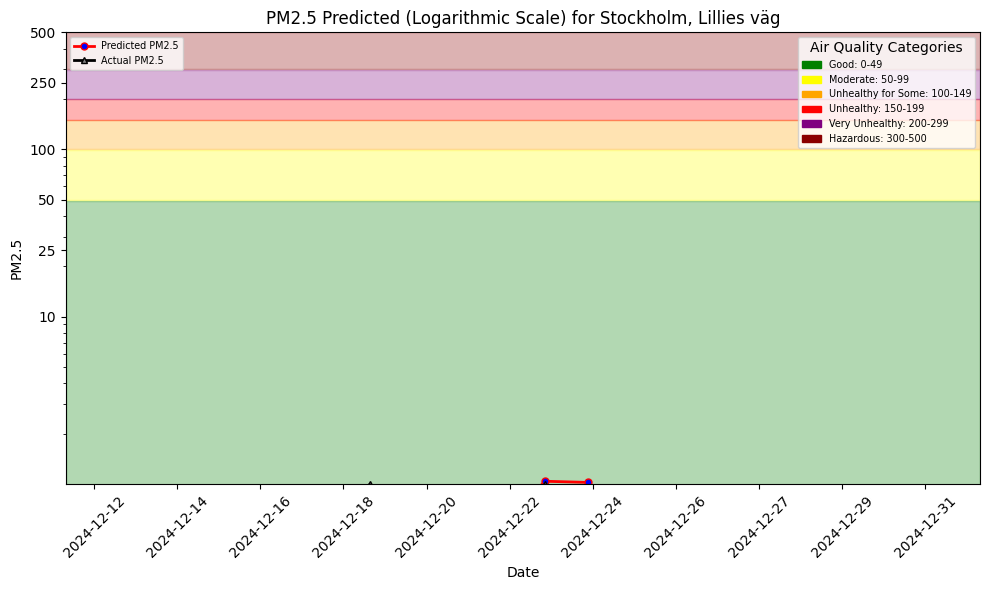

In [24]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

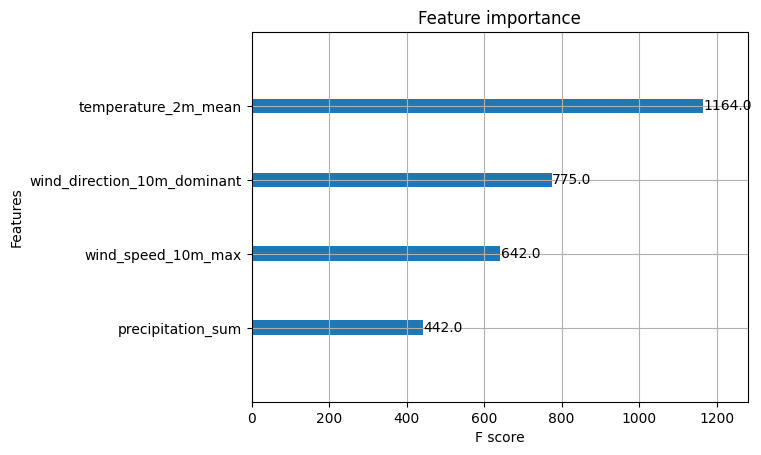

In [25]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [26]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train_adjusted)
output_schema = Schema(y_train_adjusted)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [27]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [28]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [29]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/420826 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/6148 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18931 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/44666 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/120 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/864 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1208490/models/air_quality_xgboost_model/1


Model(name: 'air_quality_xgboost_model', version: 1)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
